In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Metric MSE

In [2]:
def mean_square_error(y_pred, y_real):
    if y_pred.shape[0] != y_real.shape[0]:
        raise ValueError("Predictions must have same length than target")

    n = y_real.shape[0]
    loss = 0
    for i in range(n):
        loss += (y_real[i] - y_pred[i])**2
    loss = loss / n 
    return loss[0]

## Creating the dataset artificially

In [3]:
np.random.seed(42)
m = 100
d = 1
X = np.random.rand(m ,d)
X_b = np.hstack(( np.ones((m, 1)), X))
y = 3 * X + 5 + np.random.rand(m ,d)

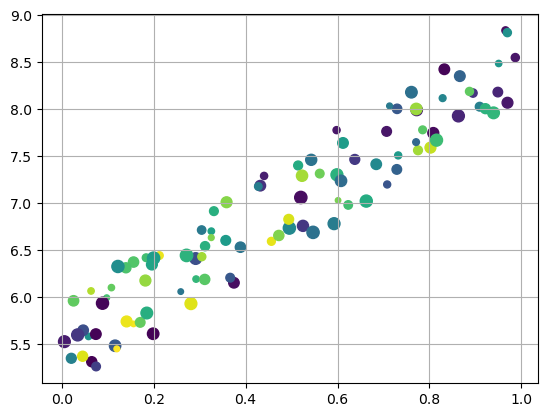

In [4]:
sizes = np.random.uniform(15, 80, len(X))
colors = np.random.uniform(15, 80, len(X))
fig, ax = plt.subplots()
ax.scatter(X, y, c=colors, s=sizes)
plt.grid()
plt.show()

# Linear regression normal equation

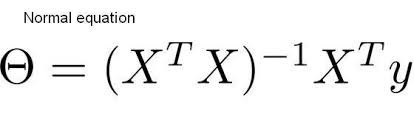

# Theta is the value that minimise de cost function

In [5]:
theta = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

In [6]:
theta

array([[5.51359766],
       [2.96646836]])

In [7]:
y_pred = theta[1][0] * X + theta[0][0]

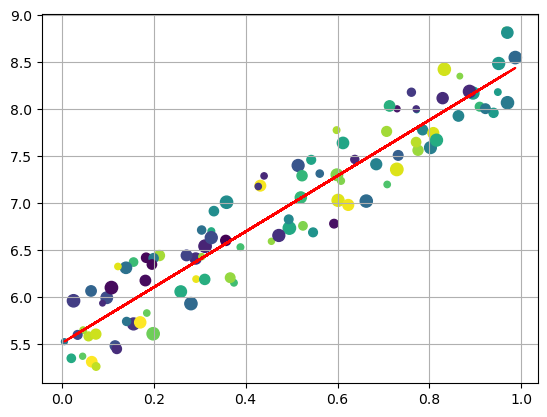

In [8]:
sizes = np.random.uniform(15, 80, len(X))
colors = np.random.uniform(15, 80, len(X))
fig, ax = plt.subplots()
ax.scatter(X, y, c=colors, s=sizes)
ax.plot(X, y_pred, c='red')
plt.grid()
plt.show()

In [9]:
print(f"Linear regression MSE with normal equation: {mean_square_error(y_pred, y)}")

Linear regression MSE with normal equation: 0.08495655256593737


# Linear regression with SVD

# Difference between inv and pinv:
## inv will return the inverse of the matrix if the det is different from 0
## pinv will return the psuedo inverse if the matrix is not inversible else it will return the inverse like inv

In [10]:
theta_svd = np.linalg.pinv(X_b) @ y

In [11]:
theta_svd

array([[5.51359766],
       [2.96646836]])

In [12]:
y_pred_svd = theta_svd[1][0] * X + theta_svd[0][0]

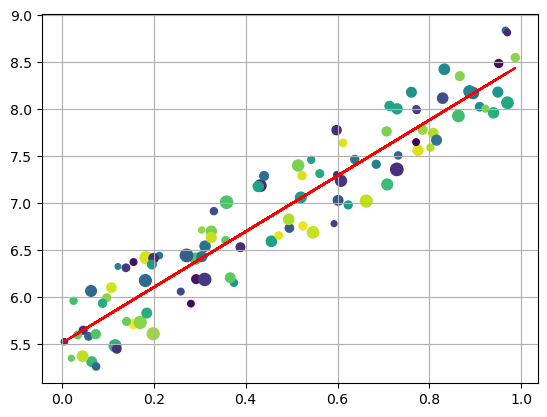

In [13]:
sizes = np.random.uniform(15, 80, len(X))
colors = np.random.uniform(15, 80, len(X))
fig, ax = plt.subplots()
ax.scatter(X, y, c=colors, s=sizes)
ax.plot(X, y_pred_svd, c='red')
plt.grid()
plt.show()

In [14]:
print(f"Linear regression MSE with SVD method: {mean_square_error(y_pred_svd, y)}")
print(f"Difference between Normal and SVD: {mean_square_error(y_pred, y) - mean_square_error(y_pred_svd, y)}")

Linear regression MSE with SVD method: 0.0849565525659374
Difference between Normal and SVD: -2.7755575615628914e-17


# Complexity algorithm
### Inversing a matrix is between O(n²,⁴) and O(n³), O(m)
### SVD approach is O(n²) and O(m)
### Where n represent the number of variables and m the number of samples

# Stochastic gradient descent approach

In [15]:
np.random.seed(42)
indices = np.random.permutation(len(X))
print(f"List of indices:\n{indices}")

X_shuffled = X[indices]
y_shuffled = y[indices]

rows, cols = X_shuffled.shape

rows_90 = np.int_(rows * 0.90)

X_train, X_test = X_shuffled[:rows_90,:], X_shuffled[rows_90:, :]
y_train, y_test = y_shuffled[:rows_90], y_shuffled[rows_90:]

List of indices:
[83 53 70 45 44 39 22 80 10  0 18 30 73 33 90  4 76 77 12 31 55 88 26 42
 69 15 40 96  9 72 11 47 85 28 93  5 66 65 35 16 49 34  7 95 27 19 81 25
 62 13 24  3 17 38  8 78  6 64 36 89 56 99 54 43 50 67 46 68 61 97 79 41
 58 48 98 57 75 32 94 59 63 84 37 29  1 52 21  2 23 87 91 74 86 82 20 60
 71 14 92 51]


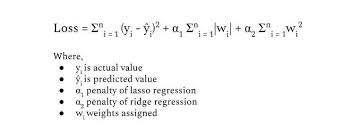

# Adding regularisation

In [16]:
class LinearRegression:
    def __init__(self, epochs=100, lr=0.01, batch_size=32, penalty="none", alpha=0.01, l1_ratio=0.5):
        if epochs < 0:
            raise ValueError("epoch must be positive")
            
        if lr < 0:
            raise ValueError("learning rate must be postive")
            
        if batch_size < 0:
            raise ValueError("Batch size must be positive")

        if penalty.lower() not in ("none", "l1", "l2", "elastic net"):
            raise ValueError("Penalty accepted are L1, L2 and Elastic net")
                                                           
        self.weight = None
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.penalty = penalty
        
    def fit(self, X, y):
        
        if X.shape[0] != y.shape[0]:
            raise ValueError(f'Features must have same dimension than as target: {X.shape[0]} != {y.shape[0]}')
            
        self.samples, self.features = X.shape
        self.weight = np.random.randn(self.features , 1).astype(np.float32)
        self.bias = np.zeros((1, 1), np.float32)
        y = np.array(y, dtype=np.float32)
       
        batches = (self.samples + self.batch_size -1) // self.batch_size
        
        for epoch in range(self.epochs):
            #Shuffle data for better generalisation
            indices = np.random.permutation(self.samples)
            X, y = X[indices], y[indices]
            
            total_loss = 0
            for batch in range(batches):
                start = batch * self.batch_size
                end = min((batch + 1) * self.batch_size, self.samples)
                
                X_batch, y_batch = X[start:end], y[start:end]
        
                y_pred = self.prediction(X_batch)
    
                loss = self.mean_square_error(y_pred, y_batch)

                #Gradient descent
                dw = np.dot(X_batch.T, (y_pred - y_batch))
                db = np.sum(y_pred - y_batch)

                #Adding regularisation
                if self.penalty == "l2":
                    dw += self.alpha * self.weight
                elif self.penalty == "l1":
                    dw += self.alpha * np.sign(self.weight)
                elif self.penalty == "elastic net":
                    dw += self.alpha * (self.l1_ratio * np.sign(self.weight) + (1 - self.l1_ratio) * self.weight)

                self.weight -= self.lr * dw
                self.bias -= self.lr * db
    
                total_loss += loss
            print(f"epoch: {epoch+1}, training loss: {total_loss/batches:.4f}")
        
            
    def mean_square_error(self, y_pred, y_true):
        
        if y_pred.shape[0] != y_true.shape[0]:
            raise ValueError("Predictions and targets must have the same dimension")
            
        n = y_true.shape[0]
        y_true = y_true.flatten()
        y_pred = y_pred.flatten()
        total_loss = 0
        omega = 0
        
        for i in range(n):
            omega = y_true[i] - y_pred[i]
            total_loss += omega**2
            
        return total_loss/n
        
    def prediction(self, X):
        if self.weight is None:
            raise ValueError("Model must be trained before calling prediction")
        
        return np.dot(X, self.weight) + self.bias
    

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.prediction(X_test)

epoch: 1, training loss: 22.0086
epoch: 2, training loss: 1.4749
epoch: 3, training loss: 0.1801
epoch: 4, training loss: 0.0978
epoch: 5, training loss: 0.0904
epoch: 6, training loss: 0.0910
epoch: 7, training loss: 0.0896
epoch: 8, training loss: 0.0894
epoch: 9, training loss: 0.0862
epoch: 10, training loss: 0.0868
epoch: 11, training loss: 0.0873
epoch: 12, training loss: 0.0869
epoch: 13, training loss: 0.0859
epoch: 14, training loss: 0.0858
epoch: 15, training loss: 0.0855
epoch: 16, training loss: 0.0844
epoch: 17, training loss: 0.0859
epoch: 18, training loss: 0.0862
epoch: 19, training loss: 0.0848
epoch: 20, training loss: 0.0867
epoch: 21, training loss: 0.0833
epoch: 22, training loss: 0.0847
epoch: 23, training loss: 0.0849
epoch: 24, training loss: 0.0865
epoch: 25, training loss: 0.0832
epoch: 26, training loss: 0.0832
epoch: 27, training loss: 0.0826
epoch: 28, training loss: 0.0831
epoch: 29, training loss: 0.0812
epoch: 30, training loss: 0.0826
epoch: 31, trainin

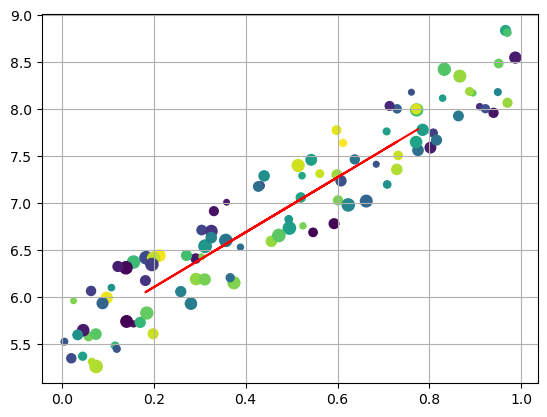

In [18]:
sizes = np.random.uniform(15, 80, len(X))
colors = np.random.uniform(15, 80, len(X))
fig, ax = plt.subplots()
ax.scatter(X, y, c=colors, s=sizes)
ax.plot(X_test, y_pred_lr, c='red')
plt.grid()
plt.show()

In [19]:
print(f"The mean squared error of SGD approach: {mean_square_error(y_pred_lr, y_test)}")

The mean squared error of SGD approach: 0.11400095769447491


# SGD Regression from scikit-learn implementation

In [20]:
from sklearn.linear_model import SGDRegressor

In [21]:
reg = SGDRegressor(loss="squared_error", max_iter=100)
reg.fit(X_train, y_train.ravel())
y_pred_reg = reg.predict(X_test)

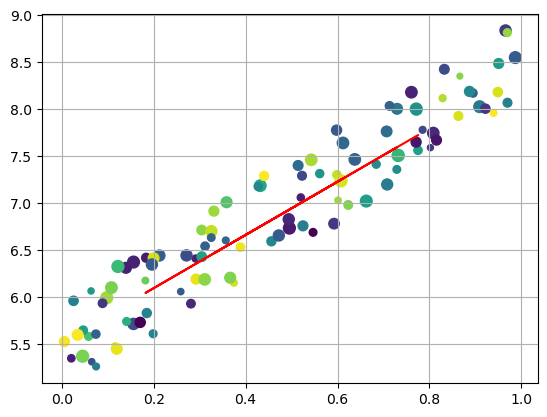

In [22]:
sizes = np.random.uniform(15, 80, len(X))
colors = np.random.uniform(15, 80, len(X))
fig, ax = plt.subplots()
ax.scatter(X, y, c=colors, s=sizes)
ax.plot(X_test, y_pred_reg, c='red')
plt.grid()
plt.show()

In [23]:
print(f"The mean squared error of sklearn SGD Regression approach: {mean_square_error(y_pred_reg, y_test)}")

The mean squared error of sklearn SGD Regression approach: 0.13339060193843597
